In [1]:
# importación de librerías
import numpy as np
import cv2
import sys
from matplotlib import pyplot as plt # necesario para mostrar imágenes en jupyter
sys.path.append("/home/marta/Documentos/Facultad/Cuarto/VC/Practicas/")
from funciones import get_match
from operator import attrgetter
from random import sample

def mostrar(imagen):
    if len(imagen.shape) == 3:
        img = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        img = imagen
        plt.imshow(img, cmap='Greys_r')
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Ejercicio 1 - Estimación de la matriz cámara a partir de puntos 3D y sus proyecciones 2D.

## Apartado a - Generar una matriz de cámara finita con valores aleatorios en [0,1]

Para que una matriz defina una cámara debe cumplir las siguientes condiciones:

* Ser una matriz $3 \times 4$.

$$ P_{3\times 4} = [M_{3\times 3} | p_{3 \times 1}]$$

* Que el determinante de la submatriz $M_{3 \times 3}$ sea distinto de cero.

$$ det(M) \neq 0$$

En la función implementada, genero una matriz $3 \times 4$ aleatoria inicial, si no cumple la condición de que su determinante de $M$ sea distinto de cero, vuelvo a generar otra matriz aleatoria, hasta conseguir una que cumpla la condición. La función `random.rand` de _Numpy_ nos asegura números aleatorios en el rango $[0,1]$.

In [2]:
def genera_camara_finita():
    P = np.random.rand(3,4)
    while np.linalg.det(P[:3,:3]) == 0:
        P = np.random.rand(3,4)
    P=P/P[-1,-1]
    return P

P = genera_camara_finita()
P

array([[ 1.29180211,  1.21478681,  0.95525993,  1.52437371],
       [ 0.91787303,  0.30912068,  1.22239269,  1.93026081],
       [ 1.62647927,  1.30905485,  1.93777885,  1.        ]])

## Apartado b - Generar puntos 3D en dos planos distintos ortogonales.

Para que los puntos generados cumplan la condición de pertenecer a dos planos distintos ortogonales deben tener la siguiente forma:

$$\{(0,x_1,x_2)\;y\;(x_2,x_1,0), \qquad\ donde\;x_1 = [0.1,0.1,1]\;y\;x_2=[0.1,0.1,1]\}$$

es decir, tanto $x_1$ como $x_2$ son todos los números desde el $0,1$ hasta el $1$ en intervalos de $0,1$: $0.1, 0.2, 0.3, \cdots 1$.

In [3]:
# función para generar puntos del mundo 3D con coordenadas {(0, x1, x2) y (x2, x1, 0)}. Es decir, una rejilla de puntos
# en dos planos distintos ortogonales. x1=0.1:0.1:1 y x2=0.1:0.1:1 significa que tenemos que generar valores de x1 y x2
# desde 0.1 a 1 y que aumenten de 0.1 en 0.1.
def genera_puntos_planos_ortogonales_distintos():
    # posibles valores para x1 y x2
    x1 = x2 = np.arange(start=0.1,stop=1,step=0.1,dtype=np.float32)
    # generamos un conjunto de puntos con todas las combinaciones de (x1,x2)
    conjunto = np.concatenate(np.array(np.meshgrid(x1,x2)).T)
    # y le añadimos una columna de ceros al principio
    zeros_vector = np.zeros(conjunto.shape[0])
    conjunto1 = np.hstack((zeros_vector[..., None], conjunto))
    # y otra al final
    conjunto2 = np.hstack((conjunto, zeros_vector[...,None]))

    return np.concatenate((conjunto1, conjunto2))

p = genera_puntos_planos_ortogonales_distintos()
p

array([[ 0.        ,  0.1       ,  0.1       ],
       [ 0.        ,  0.1       ,  0.2       ],
       [ 0.        ,  0.1       ,  0.30000001],
       [ 0.        ,  0.1       ,  0.40000001],
       [ 0.        ,  0.1       ,  0.5       ],
       [ 0.        ,  0.1       ,  0.60000002],
       [ 0.        ,  0.1       ,  0.70000005],
       [ 0.        ,  0.1       ,  0.80000001],
       [ 0.        ,  0.1       ,  0.90000004],
       [ 0.        ,  0.2       ,  0.1       ],
       [ 0.        ,  0.2       ,  0.2       ],
       [ 0.        ,  0.2       ,  0.30000001],
       [ 0.        ,  0.2       ,  0.40000001],
       [ 0.        ,  0.2       ,  0.5       ],
       [ 0.        ,  0.2       ,  0.60000002],
       [ 0.        ,  0.2       ,  0.70000005],
       [ 0.        ,  0.2       ,  0.80000001],
       [ 0.        ,  0.2       ,  0.90000004],
       [ 0.        ,  0.30000001,  0.1       ],
       [ 0.        ,  0.30000001,  0.2       ],
       [ 0.        ,  0.30000001,  0.300

## Apartado c - Proyectar los puntos 3D generados con la cámara P simulada

Para calcular la proyección de un 3D con una cámara $P$ debemos multiplicar la cámara por el punto:

$$x_{3 \times 1} = P_{3 \times 4} \cdot X_{4 \times 1}$$

Debemos convertir el punto 3D $X$ a coordenadas homogéneas (añadiéndole un $1$ como última coordenada) para poder multiplicarlo por la matriz de la cámara. Una vez hecha la multiplicación, obtenemos un vector $x$ con tres elementos, pero un punto 2D sólo tiene dos coordenadas, por lo que debemos eliminar el último elemento del vector:

$$x_x = \frac{x_x}{x_z} \qquad\ x_y = \frac{x_y}{x_z}$$

In [4]:
# función que dado un punto del mundo calcula sus coordenadas de proyección de la cámara.
# Debemos añadirle al punto x un elemento 1 para poder multiplicarlo por la matriz cámara.
camera_projection = lambda x, P: P.dot(np.hstack((x,[1])))

# Proyectar el conjunto de puntos del mundo con la cámara simulada y obtener las coordenadas píxel de su proyección
def proyecta_puntos_en_plano(camara, puntos):
    # definimos el array en el que guardaremos las coordenadas píxel de los puntos
    conjunto = np.zeros(puntos.shape)
    # iteramos sobre el array de puntos del mundo para proyectar los puntos
    for i in range(puntos.shape[0]):
        conjunto[i] = camera_projection(x=puntos[i], P=camara)

    # calculamos las coordenadas píxel diviendo la coordenada x e y por la coordenada z
    coords_pixel = np.zeros((puntos.shape[0], 2))
    for i in range(puntos.shape[0]):
        z = conjunto[i,2]
        coords_pixel[i,0] = conjunto[i,0]/z
        coords_pixel[i,1] = conjunto[i,1]/z

    return coords_pixel

c = proyecta_puntos_en_plano(camara=P, puntos=p)
c

array([[ 1.31456197,  1.57276236],
       [ 1.20971435,  1.45255692],
       [ 1.1285984 ,  1.35955931],
       [ 1.06397599,  1.28547117],
       [ 1.01128084,  1.22505736],
       [ 0.96748982,  1.17485195],
       [ 0.93052191,  1.13246907],
       [ 0.89889771,  1.09621264],
       [ 0.87153664,  1.06484378],
       [ 1.27979619,  1.45255592],
       [ 1.18735452,  1.35601344],
       [ 1.11435045,  1.27977083],
       [ 1.05523653,  1.21803456],
       [ 1.0063929 ,  1.16702417],
       [ 0.96535697,  1.12416785],
       [ 0.93039521,  1.08765514],
       [ 0.9002519 ,  1.05617465],
       [ 0.87399513,  1.0287531 ],
       [ 1.25076762,  1.35218652],
       [ 1.16828298,  1.27366787],
       [ 1.10199215,  1.2105644 ],
       [ 1.04755254,  1.15874233],
       [ 1.00204684,  1.11542462],
       [ 0.96344264,  1.07867657],
       [ 0.93028057,  1.04710898],
       [ 0.90148563,  1.01969854],
       [ 0.87624841,  0.99567477],
       [ 1.22616434,  1.26711806],
       [ 1.15182403,

## Apartado d - Implementar el algoritmo DLT

Dados unos puntos 3D, $X$ y sus proyecciones en 2D, $x$, queremos estimar la matriz de la cámara $P$.

$$ x_i = P \cdot X_i \qquad\ i = 1, \ldots, N $$

Cada punto tiene $x$ tiene 3 ecuaciones distintas:

$$ \left[ 
    \begin{array}{ccc}
    0^T & -X_i^T & y_i\cdot X_i^T \\
    X_i^T & 0^T & -x_i\cdot X_i^T \\
    -y_i \cdot X_i^T & x_i \cdot X_i^T & 0^T
    \end{array} \right] \left( \begin{array}{c}
    P^1 \\
    P^2 \\
    P^3
    \end{array} \right) = 0$$

donde cada $P^{iT}$ es un vector de 4 elementos que contiene la $i$-ésima fila de $P$. Debido a que estas tres ecuaciones son linealmente dependientes, podemos quedarnos únicamente con las dos primeras:

$$ \underbrace{\left[ 
    \begin{array}{ccc}
    X_i^T & 0^T & -x_i\cdot X_i^T\\
    0^T & X_i^T & -y_i\cdot X_i^T
    \end{array} \right]}_{M_i} \left( \begin{array}{c}
    P^1 \\
    P^2 \\
    P^3 
    \end{array} \right) = 0$$
    
Para cada punto calcularemos su matriz $M_i$ y haremos una matriz $M$ con un total de $2N$ filas. Como mínimo, $N \geq 6$, ya que la matriz $P$ tiene 12 elementos y (ignorando la escala) 11 grados de libertad, por lo que debemos tener 11 ecuaciones para resolver $P$, debido a que cada punto nos da dos ecuaciones, necesitamos como mínimo $5,5$ puntos.

Una vez hayamos obtenido la matriz $M$, pasaremos a calcular su __descomposición en valores singulares__:

$$ SVD(M) = USV^T $$

La matriz $S$ contiene los autovalores de $M$ y $V$, los autovectores. Nuestra matriz $P$ será el autovector con un menor autovalor, es decir, la última columna de la matriz $V^T$.

### Normalización

Para evitar que los valores de la matriz $M$ tengan una alta varianza, debemos normalizar los puntos antes de calcular la matriz. Para normalizar los puntos, aplicamos a cada punto la siguiente matriz de normalización:

* Si el punto es 2D:

$$ T = \left[ \begin{array}{ccc}
                s & 0 & m_x \\
                0 & s & m_y \\
                0 & 0 & 1
              \end{array} \right]$$
              
* Si el punto es 3D:

$$ U = \left[ \begin{array}{cccc}
                s & 0 & 0 & m_x \\
                0 & s & 0 & m_y \\
                0 & 0 & s & m_z \\
                0 & 0 & 0 & 1
              \end{array} \right]$$
              
Donde $s$ es la desviación media de $M$ y $m$ la media de las distintas coordenadas $x$, $y$ y $z$. Estas matrices se deben guardar, ya que se utilizan para __deshacer la normalización__ al final del algoritmo:

$$ P = T^{-1}\tilde{P}U$$

In [5]:
# Función para normalizar los puntos.
def norm_points(points):
    media = np.mean(a=points, axis=0)
    desv_std = np.std(a=points)
    dims = points.shape[1] # para saber si estamos en 3d o 2d
    if dims==2:
        Tr = np.array([[desv_std, 0, media[0]],[0, desv_std, media[1]],[0,0,1]])
    else:
        Tr = np.array([[desv_std, 0, 0, media[0]], [0, desv_std, 0, media[1]], [0, 0, desv_std, media[2]], [0,0,0,1]])

    Tr = np.linalg.inv(a=Tr)
    x = np.dot(Tr, np.concatenate((points.T, np.ones((1,points.shape[0])))))
    x = x[0:dims,:].T
    return Tr, x


# Implementación del algoritmo DLT basada en el libro Multiple View Geometry y
# http://www.maths.lth.se/matematiklth/personal/calle/datorseende13/notes/forelas3.pdf
# Entrada del algoritmo: Xi (punto del mundo) y xi (proyección del punto).
# Salida del algoritmo P (matriz 3x4 de la cámara)
def DLT(X, x):
    n = x.shape[0] # numero de puntos
    # M tendrá, para cada punto, 2 filas y 12 columnas. Sólo usamos 2 filas ya que las tres ecuaciones de la matriz M son
    # linealmente dependientes.
    M = np.zeros(shape=(2*n, 12))
    z = np.zeros(shape=(4))
    # normalizamos los puntos
    tr, xn = norm_points(x)
    Tr, Xn = norm_points(X)
    # calculamos la matriz M
    for i in range(0,2*n,2):
        j = int(i/2)
        M[i] = np.concatenate((Xn[j], [1], z, -xn[j,0]*Xn[j], [-xn[j,0]]))
        M[i+1] = np.concatenate((z, Xn[j], [1], -xn[j,1]*Xn[j], [-xn[j,1]]))
    # calculamos sus valores propios
    U,S,V = np.linalg.svd(a=M)
    # La última fila de V contiene el autovector con menor autovalor (S).
    P = (V[-1]/V[-1,-1]).reshape(3,4)
    # deshacemos la normalización
    P = np.dot(np.dot(np.linalg.pinv(tr), P), Tr)
    P = P/P[-1,-1]
    return P

dlt = DLT(X=p, x=c)
print("Matriz cámara generada")
print(P)
print("Estimación de la matriz cámara")
print(dlt)

Matriz cámara generada
[[ 1.29180211  1.21478681  0.95525993  1.52437371]
 [ 0.91787303  0.30912068  1.22239269  1.93026081]
 [ 1.62647927  1.30905485  1.93777885  1.        ]]
Estimación de la matriz cámara
[[ 1.29180211  1.21478681  0.95525993  1.52437371]
 [ 0.91787303  0.30912068  1.22239269  1.93026081]
 [ 1.62647927  1.30905485  1.93777885  1.        ]]


Las cámaras obtenidas son iguales. Por tanto, podemos concluir que hemos realizado una estimación correcta.

## Apartado e - Calcular el error de la estimación usando la norma de Frobenius

Para calcular el error de la cámara estimada he calculado su "distancia" a la cámara real:

$$ error = \sqrt{\sum_{i,j} abs(P^{real}_{ij} - P^{estimada}_{ij})^2} $$

La norma de Frobenius está implementada en numpy en la función [`linalg.norm`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html), usando el parámetro `ord=None`.

In [6]:
# Estimación del error de la cámara estimada
def estima_error(orig, estimada):
    return np.linalg.norm(x=(orig - estimada), ord=None)

print("Error en la estimación de P: ", estima_error(orig=P, estimada=dlt))

Error en la estimación de P:  2.80320321195e-14


Como dije antes, ambas cámaras son prácticamente iguales ya que para encontrar diferencias entre ambas tenemos que irnos a la 15ª cifra decimal.

## Apartado f - Mostrar en una única imagen los puntos 3D proyectados con la cámara estimada y la cámara simulada

En azul muestro los puntos proyectados con la cámara simulada y en rojo, los de la cámara estimada.

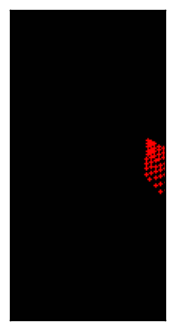

In [7]:
# Función para pintar los puntos proyectados por la cámara real y la estimada
def draw_points(real_points, estimated_points):
    # creamos una imagen vacía
    img = np.ones(shape=(200,100,3), dtype=np.uint8)
    rp = np.array(100*real_points, dtype=np.int32)
    ep = np.array(100*estimated_points, dtype=np.int32)
    # pintamos los distintos puntos
    for i in range(real_points.shape[0]):
        cv2.circle(img=img, radius= 1, center=(rp[i,0], rp[i,1]), \
                   color=(255,0,0), thickness=-1)
        cv2.circle(img=img, radius=1, center=(ep[i, 0], ep[i, 1]), \
                   color=(0, 0, 255), thickness=-1)
    mostrar(img)
    
draw_points(real_points=c, estimated_points=proyecta_puntos_en_plano(camara=dlt,puntos=p))

En la imagen sólo vemos puntos rojos ya al truncar a entero los puntos proyectados con ambas cámaras obtenemos las mismas coordenadas. Por tanto, los puntos proyectados por la cámara estimada se pintan encima de los puntos estimados por la cámara simulada, obteniendo este resultado. Esta imagen es la prueba de que la cámara estimada obtenida es una buena estimación de la cámara original.

# Ejercicio 2 - Calibración de la cámara usando homografías

## Apartado a - Leer las imágenes chessboard, determinar las válidas para calibrar una cámara, calcular sus esquinas y pintarlas

Este apartado se divide en tres partes:

* Leer las imágenes _chessboard_ y determinar las que son válidas para calibrar una cámara. Para ello, leeremos todas las imágenes y llamaremos a la función `findChessboardCorners` y comprobaremos el valor booleano devuelto por la función. Si es verdadero, la imagen es válida para calibrar una cámara.

    Para poder saber qué punto del mundo corresponde a cada esquina encontrada, definimos un sistema de coordenadas cuyo centro se encuentra en el tablero. El punto $(0,0)$ se encontraría en la esquina superior izquierda. Así, tenemos definidas de forma sencilla unas correspondencias 2D - 3D que más adelante nos ayudarán a calibrar la cámara.

* Calcular las esquinas de las imágenes. En este caso, también usamos la función `findChessboardConers` aunque esta vez nos centramos en las esquinas calculadas por la misma. Para refinar estas esquinas encontradas, usaremos la función `cornerSubPix`.

* Pintarlas sobre las mismas. Este último paso lo realizaremos llamando a la función `drawChessboardCorners`. La imagen sobre la que pintamos las esquinas debe ser una copia de la original, ya que si no ésta se verá modificada.

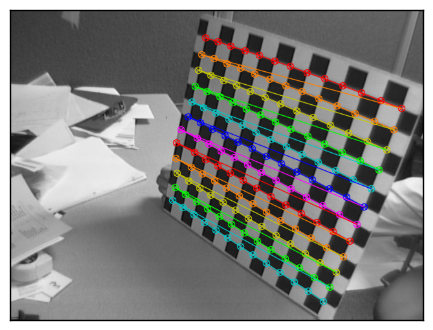

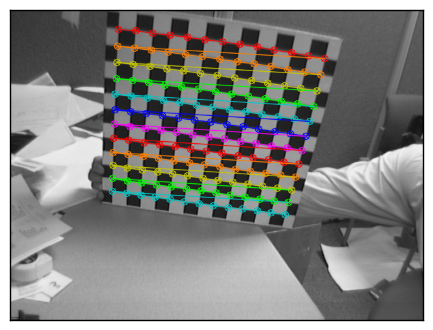

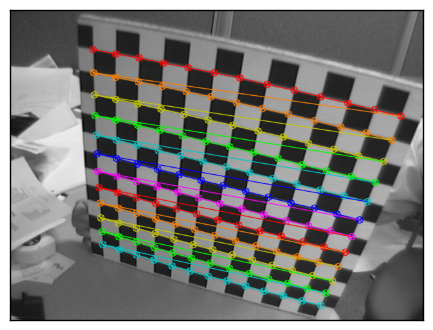

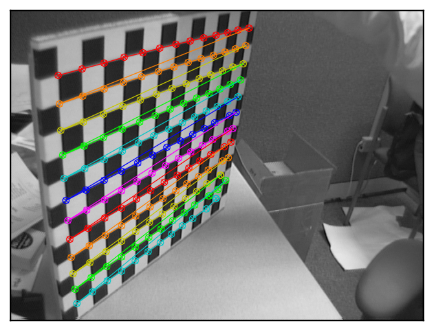

In [8]:
def find_valid_imgs(path="chessboard/Image", n_imgs=25, format=".tif", pat_size=(13,12)):
    valid_imgs = []
    for i in range(n_imgs):
        imgpath = path+str(i+1)+format
        img = cv2.imread(imgpath)
        gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        # encontrar los chess board corner
        retval, corners = cv2.findChessboardCorners(image=gray, patternSize=pat_size,
                                                    flags=(cv2.CALIB_CB_NORMALIZE_IMAGE +
                                                           cv2.CALIB_CB_ADAPTIVE_THRESH
                                                           + cv2.CALIB_CB_FAST_CHECK))
        if retval:
            valid_imgs.append(img)

    return valid_imgs

def find_and_draw_chessboard_corners(valid_images, pat_size=(13,12)):
    imgpoints = [] # puntos 2D de la imagen
    objpoints = [] # puntos 3D del mundo real. Tomando como centro del mundo el tablero.
    objp = np.zeros((pat_size[0]*pat_size[1],3),np.float32)
    objp[:,:2] = np.mgrid[0:pat_size[0], 0:pat_size[1]].T.reshape(-1,2)
    objp = objp.reshape(-1,1,3)
    gray_shape = 0

    for img in valid_images:
        gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        gray_shape = gray.shape

        # encontrar los chess board corner
        retval, corners = cv2.findChessboardCorners(image=gray, patternSize=pat_size,
                                                    flags=(cv2.CALIB_CB_NORMALIZE_IMAGE+
                                                           cv2.CALIB_CB_ADAPTIVE_THRESH
                                                           +cv2.CALIB_CB_FAST_CHECK))
        # si hemos encontrado, pasamos a refinarlos
        if retval:
            # cada llamada a esta función da un número de puntos entre 0 y patsize[1]*patsize[0]. Por tanto, nos
            # tendremos que quedar con los corners2.shape[0] primeros puntos del mundo objp
            corners2 = cv2.cornerSubPix(image=gray, corners=corners, winSize=(11,11), zeroZone=(-1,-1),
                            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            imgpoints.append(corners2)
            objpoints.append(objp)
            # mostramos los corner encontrados
            imgcorners = img.copy()
            imgdraw = cv2.drawChessboardCorners(image=imgcorners, patternSize=pat_size, corners=corners2,
                                            patternWasFound=retval)
            mostrar(imgdraw)

    return imgpoints, objpoints, gray_shape

valid_imgs = find_valid_imgs()
imgpoints, objpoints, pic_shape = find_and_draw_chessboard_corners(valid_images=valid_imgs)

Obtenemos un resultado muy bueno: las esquinas obtenidas coinciden con las esquinas del tablero y además hemos conseguido un patrón del tablero completo. Además, hemos obtenido cuatro imágenes diferentes, lo cual es suficiente para realizar la calibración.

## Apartado b - Calcular los parámetros intrínsecos y extrínsecos de la cámara para cada imagen.

### Apartado b.1 - Sin tener en cuenta la distorsión

En este caso, simplemente calibramos la cámara con los puntos encontrados. Para ello, llamamos a la función `calibrateCamera` pasándole los puntos del mundo 3D definidos por nosotros en el apartado anterior y sus correspondientes puntos 2D calculados.

In [9]:
# Función que calibra la cámara usando las esquinas encontradas
def calibrate(objpoints, imgpoints, pic_shape):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints,
                                                imageSize=pic_shape, cameraMatrix=None, distCoeffs=None)
    print("Reprojection error: ", ret)
    print("Matriz de la cámara")
    print(mtx)
    print("Parámetros intrínsecos")
    print(dist)
    print("Parámetros extrínsecos")
    print("Rotación")
    print(rvecs)
    print("Traslación")
    print(tvecs)
    return mtx, dist, rvecs, tvecs

mtx, dist, rvecs, tvecs = calibrate(objpoints=objpoints, imgpoints=imgpoints, pic_shape=pic_shape[::-1])

Reprojection error:  1.2530441330883588
Matriz de la cámara
[[ 655.60434898    0.          301.47609395]
 [   0.          661.07442009  229.11322851]
 [   0.            0.            1.        ]]
Parámetros intrínsecos
[[ -3.20158685e-01   5.70069735e-01   1.83811036e-03   2.50298437e-04
   -8.40128447e-01]]
Parámetros extrínsecos
Rotación
[array([[ 0.31415741],
       [ 0.68052338],
       [ 0.34170217]]), array([[ 0.49786271],
       [ 0.01759002],
       [ 0.13668656]]), array([[ 0.59273109],
       [ 0.22648794],
       [ 0.18040479]]), array([[ 0.54742731],
       [-0.93688702],
       [-0.14817887]])]
Traslación
[array([[ -1.70156642e-02],
       [ -7.01341231e+00],
       [  2.43633227e+01]]), array([[ -4.97716132],
       [ -7.30692205],
       [ 23.39988801]]), array([[ -4.4726202 ],
       [ -4.27157849],
       [ 16.29470727]]), array([[ -4.81690259],
       [ -2.64668033],
       [ 13.26591971]])]


### Apartado b.2 - Teniendo en cuenta la distorsión de las imágenes

En este caso, tendremos que corregir la distorsión de las mismas usando la función `undistort` y la función `getOptimalNewMatrixCamera` para calcular el parámetro `newCameraMatrix`.

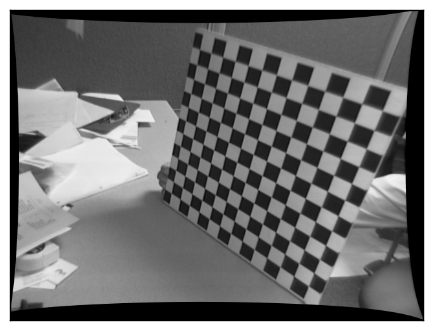

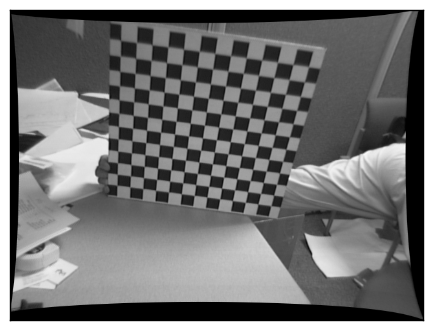

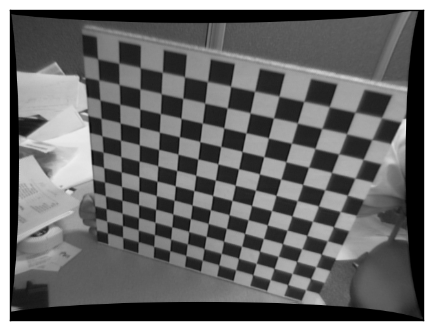

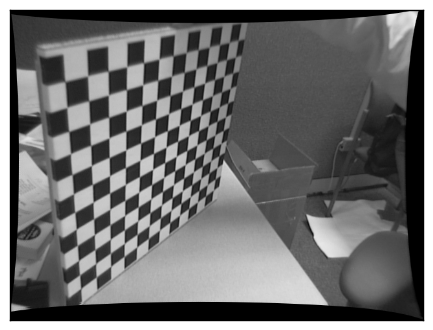

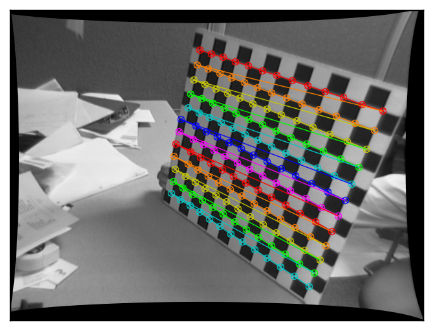

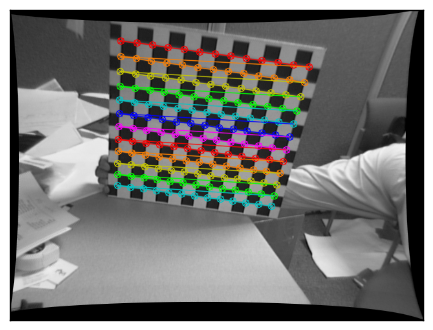

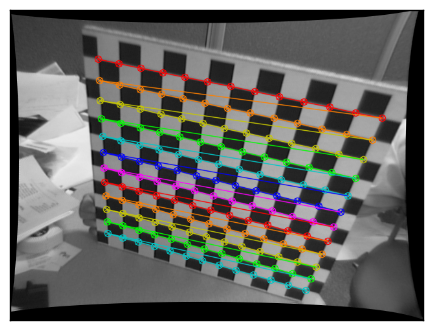

Reprojection error:  0.6982332859239562
Matriz de la cámara
[[ 577.55314942    0.          291.35483144]
 [   0.          574.59669912  230.95640172]
 [   0.            0.            1.        ]]
Parámetros intrínsecos
[[-0.01053057  0.09938842  0.00096424 -0.0005895  -0.21741831]]
Parámetros extrínsecos
Rotación
[array([[ 0.32241634],
       [ 0.68159928],
       [ 0.34317788]]), array([[ 0.50479573],
       [ 0.02005741],
       [ 0.13605564]]), array([[ 0.59996373],
       [ 0.22912076],
       [ 0.18018365]])]
Traslación
[array([[  0.05962967],
       [ -7.18455463],
       [ 24.4353916 ]]), array([[ -4.89244622],
       [ -7.47608221],
       [ 23.52985163]]), array([[ -4.41412773],
       [ -4.38855988],
       [ 16.38480756]])]


In [10]:
def calibrate_undistort(valid_images, mtx, dist, pic_shape):
    valid_und_img = []
    # calculamos la camera matrix óptima
    newmtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix=mtx, distCoeffs=dist, imageSize=pic_shape,
                                                alpha=1)
    # leemos todas las imágenes de la lista img_index, calculamos la imagen sin distorsión
    for img in valid_images:
        dst = cv2.undistort(src=img, cameraMatrix=mtx, distCoeffs=dist, newCameraMatrix=newmtx)
        # recortamos la imagen
        # x,y,w,h = roi
        # dst = dst[y:y+h, x:x+w]
        valid_und_img.append(dst)
        mostrar(dst)
    
    return valid_und_img

valid_und_imgs = calibrate_undistort(valid_images=valid_imgs, mtx=mtx, dist=dist, pic_shape=pic_shape[::-1])
imgpoints_und, objpoints_und, pic_shape_und = find_and_draw_chessboard_corners(valid_images=valid_und_imgs)
mtx_und, dist_und, rvecs_und, tvecs_und = calibrate(objpoints=objpoints_und, imgpoints=imgpoints_und, 
                                                    pic_shape=pic_shape_und)

En este caso, creo que las imágenes tenían sobre todo __distorsión radial__, ya que las correcciones que ha hecho OpenCV son de tipo radial: el centro de la foto se mantiene igual y sólo se corrigen deformaciones en los extremos.

Además, la estimación de la cámara se ha realizado correctamente, ya que como mínimo necesitamos $N \geq 3$ para realizar la calibración.

In [11]:
print("Cámara obtenida a partir de imágenes con distorsión")
print(mtx)
print("Cámara obtenida a partir de imágenes sin distorsión")
print(mtx_und)
print("########################################################")
print("Parámetros intrínsecos obtenidos a partir de imágenes con distorsión")
print(dist)
print("Parámetros intrínsecos obtenidos a partir de imágenes sin distorsión")
print(dist_und)
print("########################################################")
print("Parámetros extrínsecos de rotación obtenidos a partir de imágenes con distorsión")
print(rvecs)
print("Parámetros extrínsecos de rotación obtenidos a partir de imágenes sin distorsión")
print(rvecs_und)
print("########################################################")
print("Parámetros extrínsecos de traslación obtenidos a partir de imágenes con distorsión")
print(tvecs)
print("Parámetros extrínsecos de traslación obtenidos a partir de imágenes sin distorsión")
print(tvecs_und)

Cámara obtenida a partir de imágenes con distorsión
[[ 655.60434898    0.          301.47609395]
 [   0.          661.07442009  229.11322851]
 [   0.            0.            1.        ]]
Cámara obtenida a partir de imágenes sin distorsión
[[ 577.55314942    0.          291.35483144]
 [   0.          574.59669912  230.95640172]
 [   0.            0.            1.        ]]
########################################################
Parámetros intrínsecos obtenidos a partir de imágenes con distorsión
[[ -3.20158685e-01   5.70069735e-01   1.83811036e-03   2.50298437e-04
   -8.40128447e-01]]
Parámetros intrínsecos obtenidos a partir de imágenes sin distorsión
[[-0.01053057  0.09938842  0.00096424 -0.0005895  -0.21741831]]
########################################################
Parámetros extrínsecos de rotación obtenidos a partir de imágenes con distorsión
[array([[ 0.31415741],
       [ 0.68052338],
       [ 0.34170217]]), array([[ 0.49786271],
       [ 0.01759002],
       [ 0.13668656]]),

Los parámetros extrínsecos no se han visto afectados por la distorsión. Sólo la traslación y con una diferencia pequeña. En cambio, los parámetros intrínsecos sí que han variado muchísimo y, por tanto, podemos decir que se han visto muy afectados por la distorsión. Esto es debido a, cuando no eliminamos la distorsión de las imágenes, se incluye en los parámetros intrínsecos de la cámara.

# Ejercicio 3 - Estimación de la matriz fundamental
## Apartado a - Obtener puntos en correspondencias sobre las imágenes vmort con el mejor descriptor entre AKAZE, BRISK u ORB

En este ejercicio, lo primero que he hecho ha sido comparar los tres descriptores: AKAZE, BRISK y ORB. Para ello, he calculado correspondencias con los tres usando la función definida en la práctica anterior y he comparado las correspondencias obtenidas. He decidido que el mejor descriptor es aquel que consigue encontrar más puntos y tiene además la menor distancia mínima.

In [12]:
# función que realiza los descriptores ORB, BRISK y AKAZE
def make_descriptors(vmort1, vmort2):
    matches_a, kps1_a, kps2_a = get_match(img1=vmort1, img2=vmort2, knn_matching=False, mostrar_img=False)
    matches_b, kps1_b, kps2_b = get_match(img1=vmort1, img2=vmort2, type="BRISK", knn_matching=False,
                                          mostrar_img=False)
    matches_o, kps1_o, kps2_o = get_match(img1=vmort1, img2=vmort2, type="ORB", knn_matching=False,
                                          mostrar_img=False)

    return [matches_a, matches_b, matches_o]


# función que compara los descriptores y nos dice el mejor
def compare_descriptors(list_matches):
    # para cada elemento de la lista de matches sacamos la mínima y la máxima distancia
    getdist = attrgetter('distance')
    maxmins = np.zeros((len(list_matches), 3))
    i = 0
    for matches in list_matches:
        l = list(map(getdist, matches))
        maxmins[i] = (max(l), min(l), len(l))
        i+=1

    print(maxmins)
    # el mejor será el que encuentre un mayor número de correspondencias con la distancia más pequeña
    best = np.where((maxmins[:,1] == min(maxmins[:,1])) | (maxmins[:,2] == max(maxmins[:,2])))[0][0]
    return ["AKAZE","BRISK","ORB"][best]

vmort1 = cv2.imread("vmort/Vmort1.pgm")
vmort2 = cv2.imread("vmort/Vmort2.pgm")
list_matches = make_descriptors(vmort1=vmort1, vmort2=vmort2)
maxmins = compare_descriptors(list_matches = list_matches)
print("Mejor descriptor: ",maxmins)

[[  732.89971924    47.02127075  1902.        ]
 [  799.91125488    24.61706734  3367.        ]
 [  439.5463562     25.11971283   294.        ]]
Mejor descriptor:  BRISK


En esta matriz se representa en cada fila un descriptor, siendo la primera fila correspondiente a AKAZE; la segunda, a BRISK y la tercera, a ORB. Cada columna representa la mayor distancia (entre dos puntos en correspondencias), la menor distancia y el número de puntos en correspondencias respectivamente.

Como vemos, el BRISK ha sido el descriptor que ha encontrado un mayor número de correspondencias y, además, ha obtenido la menor distancia. ORB ha obtenido una mayor distancia muy pequeña, pero el número de puntos encontrado ha sido mínimo por lo que no era un buen descriptor.

Una vez obtenido el mejor descriptor, obtengo los puntos en correspondencia.

In [13]:
matches, kps1, kps2 = get_match(img1=vmort1, img2=vmort2, type=maxmins, knn_matching=False,mostrar_img=False)

## Apartado b - Calcular $F$ por el algoritmo de los 8 puntos + RANSAC
Dos fotografías de una misma escena, realizadas desde diferentes perspectivas están relacionadas entre sí por la _geometría epipolar_. Cuando conocemos los parámetros intrínsecos de las imágenes, la matriz $3 \times 3$ que describe la relación entre ambas imágenes se denomina _matriz esencial_, y en el caso contraio, _matriz fundamental_. Este último es el caso en el que nos encontramos en este apartado:

$$ q^T \underbrace{K_2^{-T} R[t]_x K_1^{-1}}_F p = 0$$

Para estimar la _matriz fundamental_ existen varios métodos, como por ejemplo, el _algoritmo de los 8 puntos_, el cual necesita tener, como mínimo, 8 puntos en correspondencias entre ambas imágenes. 

Sean $x = (u,v,1)^T$ y $x' = (u',v',1)^T$ dos puntos en correspondencia y $f_{xy}$ elementos de la matriz $F$, obtenemos la siguiente ecuación:

$$uu'f_{11} + vu'f_{12} + u'f_{13} + uv'f_{21} + vv'f_{22} + v'f_{23} + uf_{31} + vf_{32} + f_{33} = 0$$

Con las $n$ ($n > 8$) ecuaciones que obtenemos, construimos la siguiente matriz:

$$ \left[ 
    \begin{array}{ccccccccc}
    u_1 u_1' & v_1 u_1' & u_1' & u_1 v_1' & v_1 v_1' & v_1' & u_1 & v_1 & 1 \\
    u_2 u_2' & v_2 u_2' & u_2' & u_2 v_2' & v_2 v_2' & v_2' & u_2 & v_2 & 1 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    u_n u_n' & v_n u_n' & u_n' & u_n v_n' & v_n v_n' & v_n' & u_n & v_n & 1
    \end{array} \right] \left[ \begin{array}{c}
    f_{11} \\
    f_{12} \\
    f_{13} \\
    f_{21} \\
    f_{22} \\
    f_{23} \\
    f_{31} \\
    f_{32} \\
    f_{33}
    \end{array} \right] = 0$$
    
Y en vez de resolver $Af = 0$, nos quedamos con la $f$ que minimice $|| Af ||$, es decir, el último autovector de $A^T A$.

Para realizar este apartado me he basado en la [documentación de OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html).

En primer lugar, guardo las coordenadas de los `keyPoints` encontrados y, después, calculo $F$ con la función `findFundamentalMat`. Por último, filtro los puntos obtenidos usando la máscara calculada por `findFundamentalMat`.

In [14]:
# función que implementa el algoritmo de los 8 puntos + RANSAC.
def find_fundamental_matrix(matches, kps1, kps2):
    pts1 = []
    pts2 = []
    for m in matches:
        pts1.append(kps1[m.queryIdx].pt)
        pts2.append(kps2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(points1=pts1, points2=pts2)
    # seleccionamos solo inliers
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    print("Matriz fundamental")
    print(F)

    return F, pts1, pts2

F, pts1, pts2 = find_fundamental_matrix(matches=matches, kps1=kps1, kps2=kps2)

Matriz fundamental
[[ -1.25495356e-07  -7.35427563e-05   1.86072898e-02]
 [  7.28150471e-05   9.56486101e-06  -5.70300791e-02]
 [ -1.88589532e-02   5.22261945e-02   1.00000000e+00]]


## Apartado c - Dibujar las líneas epipolares sobre ambas imágenes.

He implementado una función para dibujar las líneas epipolares sobre una imagen. Para ello, calculo las líneas epipolares usando la función `computeCorrespondEpilines` de OpenCV y calculo dos puntos (($x_0, y_0$) y ($x_1, y_1$)) sobre los que dibujar la recta en la imagen.

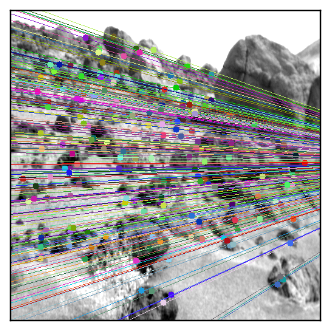

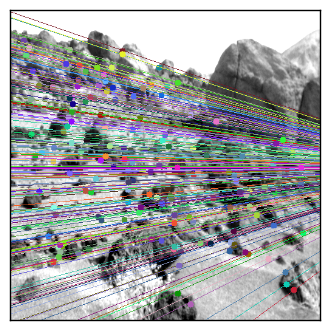

In [15]:
# función para dibujar las líneas epipolares en las imágenes
def find_and_draw_epipolar_lines(img, pts, pts_other, F, index, n=200):
    # en primer lugar calculamos las líneas epipolares
    lines = cv2.computeCorrespondEpilines(points=pts_other.reshape(-1,1,2), whichImage=index, F=F)
    lines.reshape(-1,3)
    r,c = img.shape[:2]
    # tomamos n indices aleatorios para pintar
    indices = sample(range(len(lines)), n)
    for l,pt in zip(lines[indices], pts[indices]):
        l = l[0]
        # generamos un color aleatorio
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -l[2]/l[1]])
        x1, y1 = map(int, [c, -(l[2]+l[0]*c)/l[1]])
        img = cv2.line(img=img, pt1=(x0,y0), pt2=(x1, y1), color=color, thickness=1)
        img = cv2.circle(img=img, center=tuple(pt), radius=5, color=color, thickness=-1)
    return lines

lines1 = find_and_draw_epipolar_lines(img=vmort1, pts=pts1, pts_other=pts2, F=F, index=2)
mostrar(vmort1)
lines2 = find_and_draw_epipolar_lines(img=vmort2, pts=pts2, pts_other=pts1, F=F, index=1)
mostrar(vmort2)

El resultado obtenido es bastante bueno, ya que, a simple vista, los puntos en correspondencias calculados se encuentran sobre su correspondiente línea epipolar.

## Apartado d - Verificar la bondad de $F$ calculando la media de la distancia ortogonal entre los puntos soporte y sus líneas epipolares en ambas imágenes. Mostrar el error medio.

Para poder realizar este apartado, he definido varias funciones. En primer lugar, he definido una función para calcular la distancia entre un punto y una recta. Para ello, me he basado en la fórmula dada en [Wikipedia](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line):

$$ distance(ax + by + c = 0, (x_0, y_0)) = \frac{\left| ax_0 + by_0 + c \right|}{\sqrt{a^2 + b^2}}$$

Después, he definido una función para calcular la media del cuadrado de la distancia entre cada punto y su correspondiente recta epipolar:

$$ \sum_i d(x_i, F x_i')^2 $$

Por último, he definido una función para calcular el __error epipolar simétrico__:

$$ \sum_i d(x_i, F x_i')^2 + d(x_i', F x_i)^2 $$

In [16]:
# función que calcula la distancia entre un punto y una línea
# fuente: https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
def distance_point_line(point, line):
    x0, y0 = point
    a, b, c = line
    return np.abs(a*x0 + b*y0 + c)/np.sqrt(a*a + b*b)

# función que calcula las distancias al cuadrado entre los puntos y sus líneas epipolares y finalmente devuelve la media
def epipolar_distance_points_lines(points, lines):
    n = points.shape[0]
    distance = np.zeros(n, np.float32)
    for i in range(n):
        d = distance_point_line(point=points[i], line=lines[i][0])
        distance[i] = d
    return np.mean(distance)

# función que calcula el error epipolar simétrico
def epipolar_symmetric_error(points1, lines1, points2, lines2):
    # calculamos la media de las distancias de cada punto a su línea epipolar
    distance1 = epipolar_distance_points_lines(points=points1, lines=lines1)
    distance2 = epipolar_distance_points_lines(points=points2, lines=lines2)
    # aplicamos la fórmula
    return (distance1 + distance2)/2

error_epipolar = epipolar_symmetric_error(points1=pts1, lines1=lines1, points2=pts2, lines2=lines2)
print("Error al estimar F:", error_epipolar)

Error al estimar F: 1.01102924347


Como se veía en las líneas epipolares pintadas sobre las imágenes, la estimación de $F$ parecía ser bastante buena. Debido a que tiene un error bastante bajo, podemos confirmar la afirmación que hicimos antes.